# Main Script to Load, Transform and Analyse data for Final Assigment

## Data load from local file "HM Land Registry - Price Paid Data property sales in Greater London - Raw Data.csv"

# Import required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import locale # Used 
import chardet # File london-borough-profiles.csv has an unknown encoding type
import yaml # Used to manage configuration Parameters, I'm using it at work and it's so easy to set configurable constant values 

# Loading config file

In [2]:
cnf_file = open(f"config.yaml", 'r')
conf_dictionary = yaml.full_load(cnf_file)
config = conf_dictionary["default"]

# Set the locale to display the currency format
locale.setlocale(locale.LC_ALL, '')

'English_United Kingdom.1252'

# Load data from CSV file

In [3]:
df1 = pd.read_csv("Data\Property sales in Greater London - 2018.csv", parse_dates=[config['parse_dates']], dayfirst=False)
df2 = pd.read_csv("Data\Property sales in Greater London - 2019.csv", parse_dates=[config['parse_dates']], dayfirst=False)
df3 = pd.read_csv("Data\Property sales in Greater London - 2020.csv", parse_dates=[config['parse_dates']], dayfirst=True)
df4 = pd.read_csv("Data\Property sales in Greater London - 2021.csv", parse_dates=[config['parse_dates']], dayfirst=True)
df5 = pd.read_csv("Data\Property sales in Greater London - 2022.csv", parse_dates=[config['parse_dates']], dayfirst=True)

with open("Data\london-borough-profiles.csv", 'rb') as f:
    result = chardet.detect(f.read())  # or readline if the file is large

df_boroughs = pd.read_csv("Data\london-borough-profiles.csv", encoding=result['encoding'])

# The below file was created manually researching how can each of the boroughs be categorized geographycally 
# according to their location relative to the River Thames (5 Categories [North London, Inner London, East London, South London, West London])
df_locations = pd.read_csv("Data\London Boroughs and Location.csv")


### Defining a function to plot graphs easier 

In [4]:
def plot_ts(axes, x, y, color, xlabel, ylabel):
    axes.plot(x, y, color=color)
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel, color=color)
    axes.tick_params('y', colors=color)


# Merging all Dataframes

In [5]:
df = pd.concat([df1, df2, df3, df4, df5])
df1 = df2 = df3 = df4 = df5 = None

# Renaming columns from both DFs

In [6]:
keys   = ['unique_id','price_paid','deed_date','postcode','property_type','new_build','estate_type','saon','paon','street','locality','town','district','county','transaction_category','linked_data_uri']
values = ['Id','Value','Purchased Date','Postcode','Property Type','New Build','Estate Type','Saon','Paon','Street','Locality','Town','District','County','Transaction Category','URL']
dict_cols = dict(zip(keys, values))
df.rename(columns=dict_cols, inplace=True)

### Ordering and Cleansing the data

In [7]:
col_order = ['Id','Purchased Date','Postcode','Property Type','Value','New Build','Estate Type','Transaction Category','Saon','Paon','Street','Locality','Town','District','County','URL']
df = df[col_order]
for col in ['Saon','Paon','Street','Locality','Town','District','County']:
    df[col] = df[col].str.title()
    
# Renaming values on Property Type
property_type_replace = {'D': 'Detached', 'S': 'Semi-Detached', 'T': 'Terraced', 'F': 'Flats/Maisonettes', 'O': 'Other'}
df.replace({"Property Type": property_type_replace}, inplace=True)

# Renaming values on New properties as False, True
df.replace({'New Build': {'Y': True, 'N': False}}, inplace=True)

# Renaming Transaction Category
df.replace({'Transaction Category': {'A': 'Standard Price Paid', 'B': 'Additional Price Paid'}}, inplace=True)

# Renaming Duration tenancy
df.replace({'Estate Type': {'F': 'Freehold', 'L': 'Leasehold'}}, inplace=True)

# Adding Areas values with title style for easier merging
df_boroughs['Area'] = df_boroughs['Area'].str.title()


# Adding Borough values with title style for easier merging
df_locations['Borough'] = df_locations['Borough'].str.title()

# Removing properties under £10.000
df = df.drop(df[df.Value <= 10000].index)
# Merging df3 and df4
df_boroughs = pd.merge(df_boroughs, df_locations[['Borough', 'Location']], how="left", left_on='Area', right_on='Borough', copy=True)

# Merging df and df_boroughs
df = pd.merge(df, df_boroughs[['Area', 'Inner-Outer', 'Population', 'Location']], how="left", left_on='District', right_on='Area', copy=True).drop(columns=['Area'])
# df = pd.merge(df, tempDF, how='left', left_on=["Id"], right_on=['Temp_id'], copy=True).drop(columns=['Temp_id'])

filename = 'Property Sales in Greater London - Merged'
compression_options = dict(method='zip', archive_name=f'{filename}.csv')

df.to_csv(f'{filename}.zip', compression=compression_options, index=False)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 489333 entries, 0 to 489332
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Id                    489333 non-null  object        
 1   Purchased Date        489333 non-null  datetime64[ns]
 2   Postcode              488897 non-null  object        
 3   Property Type         489333 non-null  object        
 4   Value                 489333 non-null  int64         
 5   New Build             489333 non-null  bool          
 6   Estate Type           489333 non-null  object        
 7   Transaction Category  489333 non-null  object        
 8   Saon                  183040 non-null  object        
 9   Paon                  489333 non-null  object        
 10  Street                489293 non-null  object        
 11  Locality              31255 non-null   object        
 12  Town                  489333 non-null  object        
 13 

In [8]:
df.head()

,Id,Purchased Date,Postcode,Property Type,Value,New Build,Estate Type,Transaction Category,Saon,Paon,Street,Locality,Town,District,County,URL,Inner-Outer,Population,Location
0,7E86B6FB-423C-458C-E053-6B04A8C0C84C,2018-11-30,BR1 1AA,Flats/Maisonettes,99000,False,Leasehold,Standard Price Paid,Flat 28,Henry House,Ringers Road,NaN,Bromley,Bromley,Greater London,http://landregistry.data.gov.uk/data/ppi/trans...,Outer London,318300.0,South London
1,7E86B6FB-4232-458C-E053-6B04A8C0C84C,2018-11-23,BR1 1AF,Flats/Maisonettes,400000,False,Leasehold,Standard Price Paid,Flat 12,William House,Ringers Road,NaN,Bromley,Bromley,Greater London,http://landregistry.data.gov.uk/data/ppi/trans...,Outer London,318300.0,South London
2,773788C3-19BF-2CE4-E053-6C04A8C05E57,2018-08-23,BR1 1AF,Flats/Maisonettes,295000,False,Leasehold,Standard Price Paid,Flat 16,William House,Ringers Road,NaN,Bromley,Bromley,Greater London,http://landregistry.data.gov.uk/data/ppi/trans...,Outer London,318300.0,South London
3,7011B109-CAF9-8ED6-E053-6B04A8C075C1,2018-05-10,BR1 1AF,Flats/Maisonettes,315000,False,Leasehold,Standard Price Paid,Flat 20,William House,Ringers Road,NaN,Bromley,Bromley,Greater London,http://landregistry.data.gov.uk/data/ppi/trans...,Outer London,318300.0,South London
4,6B32222C-9AAE-01F1-E053-6C04A8C0D2C8,2018-03-14,BR1 1AF,Flats/Maisonettes,275000,False,Leasehold,Standard Price Paid,Flat 35,William House,Ringers Road,NaN,Bromley,Bromley,Greater London,http://landregistry.data.gov.uk/data/ppi/trans...,Outer London,318300.0,South London


# Explore the data

In [9]:
print("Dataframe shape:")
print(df.shape )

print("Dataframe columns:")
print(df.columns)


Dataframe shape:
(489333, 19)
Dataframe columns:
Index(['Id', 'Purchased Date', 'Postcode', 'Property Type', 'Value',
       'New Build', 'Estate Type', 'Transaction Category', 'Saon', 'Paon',
       'Street', 'Locality', 'Town', 'District', 'County', 'URL',
       'Inner-Outer', 'Population', 'Location'],
      dtype='object')


# Index of Property Market - Yearly Variation

### Convert date column to datetime format, set it as index and create a Year column out of it

In [10]:

df['Purchased Date'] = pd.to_datetime(df['Purchased Date'])
df['Date Index'] = df['Purchased Date']
df.set_index('Date Index', inplace=True)
df['Year'] = df.index.year
df.index

DatetimeIndex(['2018-11-30', '2018-11-23', '2018-08-23', '2018-05-10',
               '2018-03-14', '2018-06-08', '2018-05-25', '2018-03-28',
               '2018-10-09', '2018-05-31',
               ...
               '2022-03-30', '2022-04-04', '2022-11-21', '2022-10-31',
               '2022-03-31', '2022-07-29', '2022-06-21', '2022-05-11',
               '2022-03-04', '2022-01-31'],
              dtype='datetime64[ns]', name='Date Index', length=489333, freq=None)

In [11]:
# remove extremely low and high values
value_min = df['Value'].quantile(0.05)
value_max = df['Value'].quantile(0.95)

df_last_year = df.loc['2022-']
df_last_year = df_last_year[(df_last_year['Value'] >= value_min) & (df_last_year['Value'] <= value_max)]
average_value = df_last_year['Value'].mean()
# Calculate the range of property values
value_range = df_last_year['Value'].max() - df_last_year['Value'].min()
# f"{df_last_year['Value'].max()} - {df_last_year['Value'].min()}"


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


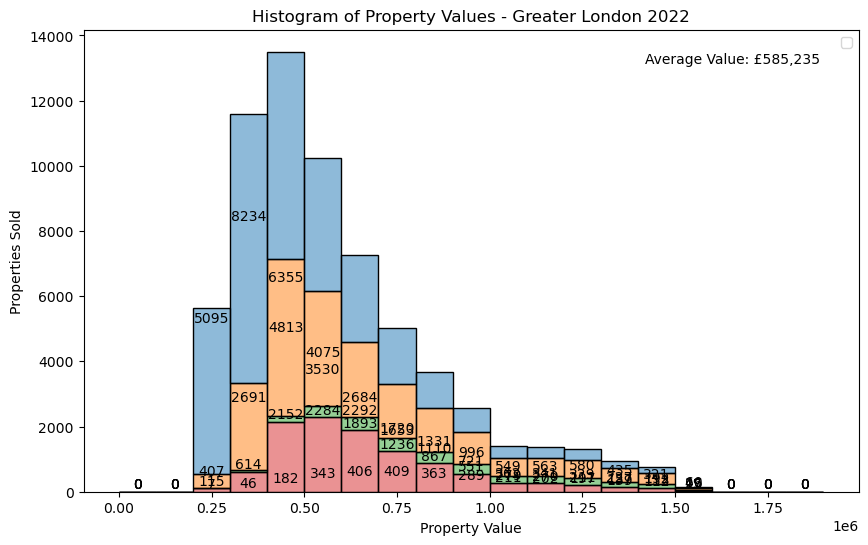

In [12]:

# Plot histogram
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(df_last_year, x='Value', bins=range(0, 2000000, 100000), hue='Property Type', alpha=0.5, multiple='stack')

# Add annotations
for patch in ax.patches:
    bin_center = patch.get_x() + patch.get_width() / 2
    bin_count = patch.get_height()
    ax.annotate(f"{int(bin_count)}", xy=(bin_center, bin_count), ha='center', va='bottom')

ax.legend()
ax.set_xlabel('Property Value')
ax.set_ylabel('Properties Sold')
ax.set_title('Histogram of Property Values - Greater London 2022')
label = locale.format_string('%.0f', val=average_value, grouping=True, monetary=False)
# Add the range value of the property
ax.text(0.95, 0.95, f"Average Value: {locale.currency(average_value, grouping=True)[:-3]}", transform=ax.transAxes, ha='right', va='top')
plt.legend()
plt.show()


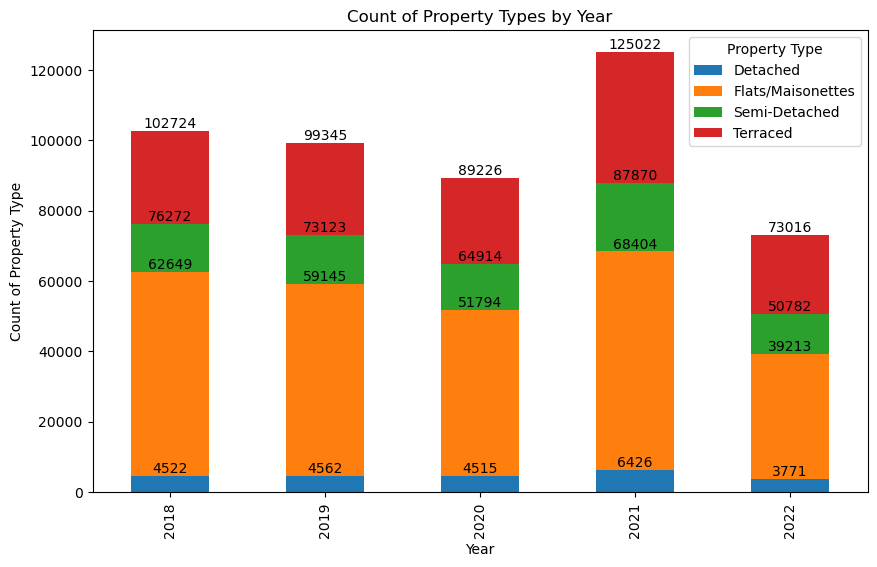

In [13]:
# group the data by 'Year' and 'Property Type', and get the count
df_grouped = df.groupby(['Year', 'Property Type']).size().reset_index(name='Count')

# pivot the data to make 'Property Type' values as columns
df_pivot = df_grouped.pivot(index='Year', columns='Property Type', values='Count')

# plot a stacked bar chart
ax = df_pivot.plot(kind='bar', stacked=True, figsize=(10, 6))

# set the axis Labels and Title
ax.set_xlabel('Year')
ax.set_ylabel('Count of Property Type')
ax.set_title('Count of Property Types by Year')

# annotate the values on the chart
for i in ax.containers:
#     label = locale.format_string('%.0f', val=i, grouping=True, monetary=False)
    ax.bar_label(i, label_type='edge', fontsize=10)

# display the chart
plt.show()

### Percentage of Price Variation by Quarter

### Set date column as the index

### Group data by year, aggregate by value and plot this

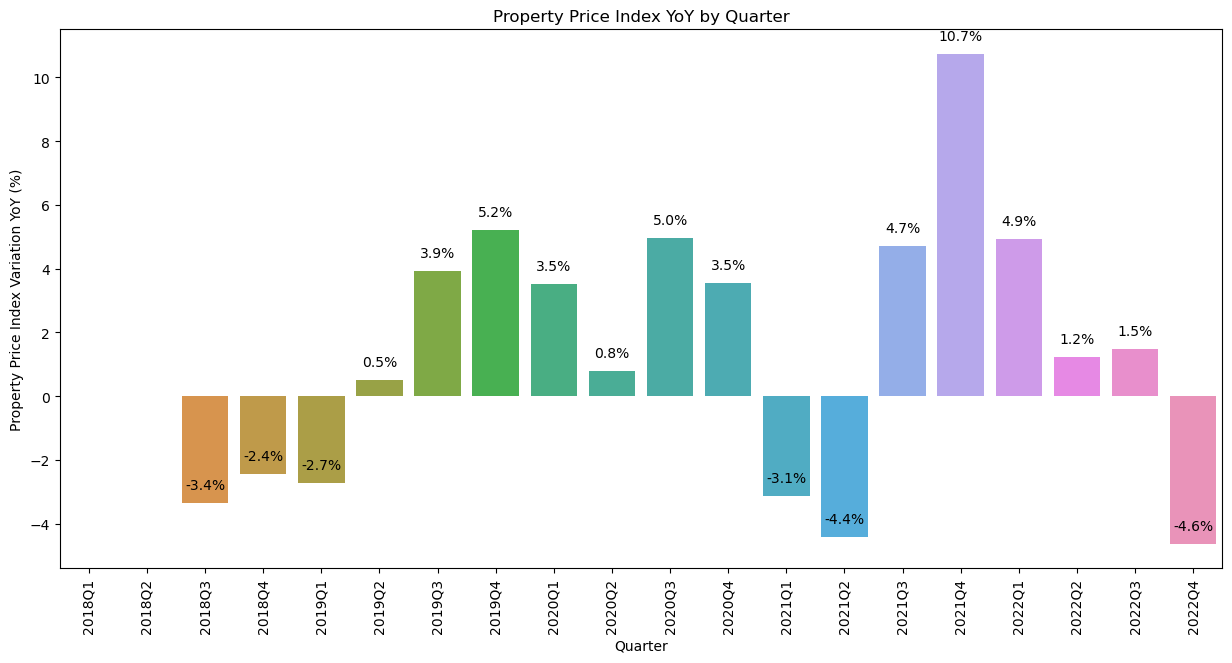

In [14]:
# Calculate "Property price index, % YoY" for each quarter
df['Year'] = df.index.to_period('Y')
df['Quarter'] = df.index.to_period('Q')
df['Month'] = df.index.to_period('M')

quarterly_mean = df.groupby(['Year', 'Quarter'])['Value'].mean().reset_index()
quarterly_mean['% YoY'] = quarterly_mean['Value'].pct_change(periods=2) * 100

# Plotting the bar graph
plt.figure(figsize=(15, 7))
ax = sns.barplot(x='Quarter', y='% YoY', data=quarterly_mean, errorbar=None)

# Function to add labels to the bars
def add_bar_labels(ax, format_string='{:.1f}'):
    for p in ax.patches:
        ax.annotate(format_string.format(p.get_height()), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='baseline', 
                    xytext=(0, 10), 
                    textcoords='offset points')

# Adding the labels to the bars
add_bar_labels(ax, format_string='{:.1f}%')

# Finalizing the plot
plt.xlabel('Quarter')
plt.ylabel('Property Price Index Variation YoY (%)')
plt.title('Property Price Index YoY by Quarter')
plt.xticks(rotation=90)
plt.show()

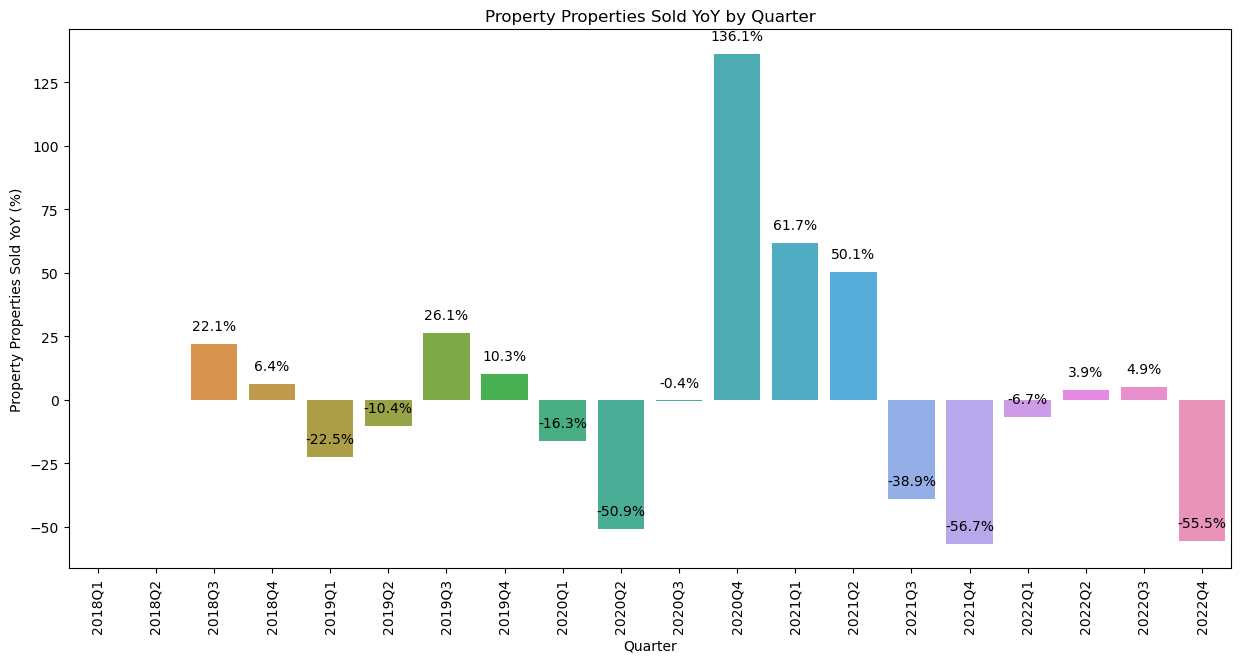

In [15]:
# Calculate "Property price index, % YoY" for each quarter
df['Year'] = df.index.to_period('Y')
df['Quarter'] = df.index.to_period('Q')
df['Month'] = df.index.to_period('M')

quarterly_mean = df.groupby(['Year', 'Quarter'])['Id'].count().reset_index()
quarterly_mean['Properties Sold'] = quarterly_mean['Id'].pct_change(periods=2) * 100

# Plotting the bar graph
plt.figure(figsize=(15, 7))
ax = sns.barplot(x='Quarter', y='Properties Sold', data=quarterly_mean, errorbar=None)

# Function to add labels to the bars
def add_bar_labels(ax, format_string='{:.1f}'):
    for p in ax.patches:
        ax.annotate(format_string.format(p.get_height()), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='baseline', 
                    xytext=(0, 10), 
                    textcoords='offset points')

# Adding the labels to the bars
add_bar_labels(ax, format_string='{:.1f}%')

# Finalizing the plot
plt.xlabel('Quarter')
plt.ylabel('Property Properties Sold YoY (%)')
plt.title('Property Properties Sold YoY by Quarter')
plt.xticks(rotation=90)
plt.show()

In [16]:
quarterly_mean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype        
---  ------           --------------  -----        
 0   Year             20 non-null     period[A-DEC]
 1   Quarter          20 non-null     period[Q-DEC]
 2   Id               20 non-null     int64        
 3   Properties Sold  18 non-null     float64      
dtypes: float64(1), int64(1), period[A-DEC](1), period[Q-DEC](1)
memory usage: 768.0 bytes


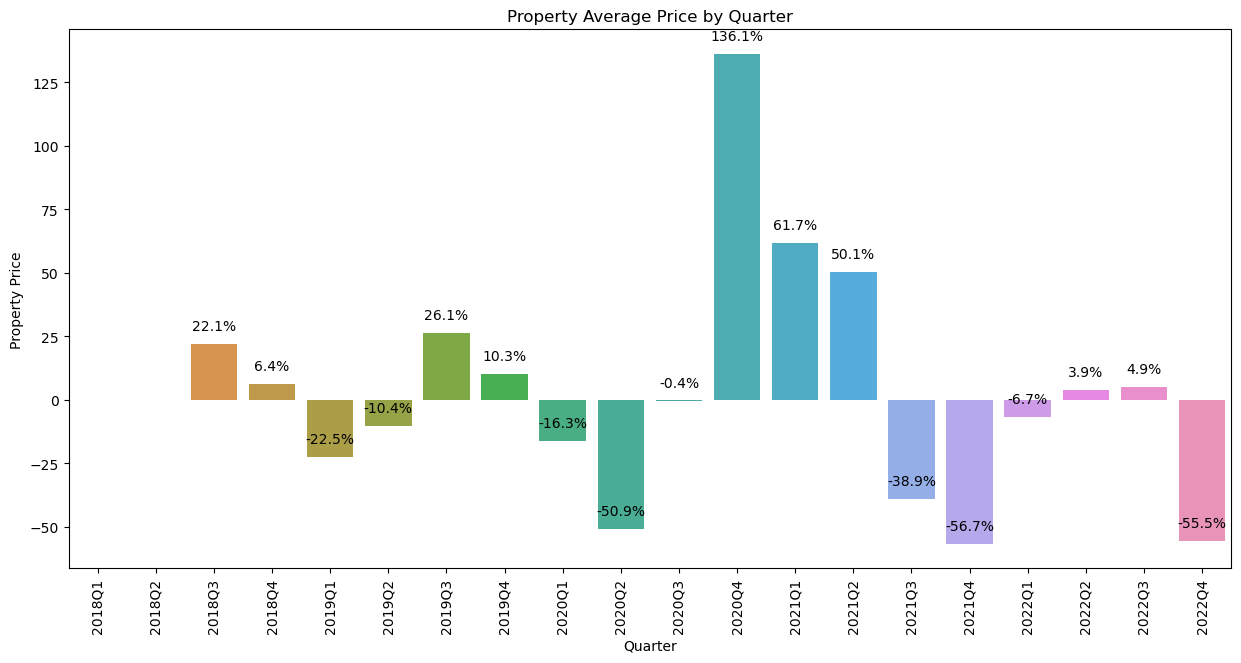

In [17]:
# Plotting the bar graph
plt.figure(figsize=(15, 7))
ax = sns.barplot(x='Quarter', y='Properties Sold', data=quarterly_mean, errorbar=None)

# Function to add labels to the bars
def add_bar_labels(ax, format_string='{:.1f}'):
    for p in ax.patches:
        ax.annotate(format_string.format(p.get_height()), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='baseline', 
                    xytext=(0, 10), 
                    textcoords='offset points')

# Adding the labels to the bars
add_bar_labels(ax, format_string='{:.1f}%')

# Finalizing the plot
plt.xlabel('Quarter')
plt.ylabel('Property Price')
plt.title('Property Average Price by Quarter')
plt.xticks(rotation=90)
plt.show()

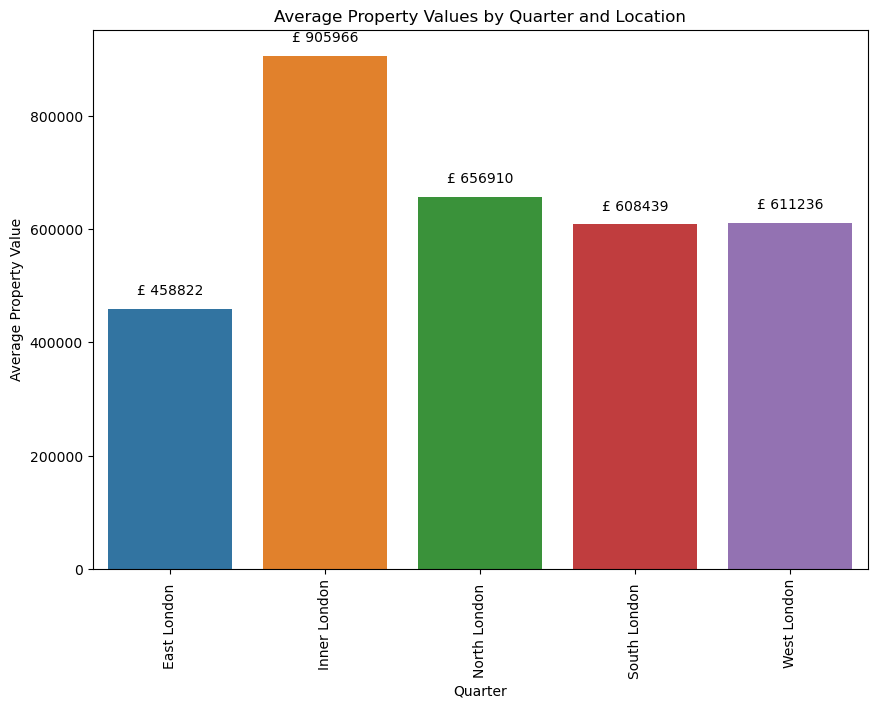

In [18]:
quarterly_mean = df.groupby(['Year', 'Quarter','Location'])['Value'].mean().reset_index()

# Plotting the bar graph
plt.figure(figsize=(10, 7))
ax = sns.barplot(x='Location', y='Value', data=quarterly_mean.loc[quarterly_mean['Year'] == '2022'], errorbar=None)

# Function to add labels to the bars
def add_bar_labels(ax, format_string='{:.0f}'):
    for p in ax.patches:
        ax.annotate(format_string.format(p.get_height()), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='baseline', 
                    xytext=(0, 10), 
                    textcoords='offset points')

# Adding the labels to the bars
add_bar_labels(ax, format_string='£ {:.0f}')

# Finalizing the plot
plt.xlabel('Quarter')
plt.ylabel('Average Property Value')
plt.title('Average Property Values by Quarter and Location')
plt.xticks(rotation=90)
plt.show()

# Plot a histogram of property values

count        20.000000
mean     648274.354788
std      152012.441173
min      444431.977926
25%      582335.727299
50%      635980.687194
75%      666576.172916
max      963804.970300
Name: Value, dtype: float64


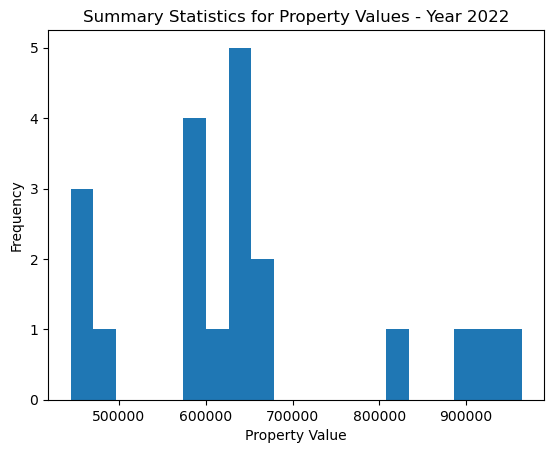

In [19]:
# temp = quarterly_mean.loc[quarterly_mean['Year'] == '2022']
temp = quarterly_mean[quarterly_mean['Year'] == '2022'].copy()
# temp.to_csv("data.csv", index=False)
# Print summary statistics for the "Value" column
print(temp['Value'].describe())
plt.hist(temp['Value'], bins=20)
plt.xlabel('Property Value')
plt.ylabel('Frequency')
plt.title('Summary Statistics for Property Values - Year 2022')
plt.show()

# Plot time series of average property values for each location

locations = temp['Location'].unique()
temp["Quarter"]= temp["Quarter"].dt.strftime('%Y-%Q')

for loc in locations:
    loc_temp = temp[temp['Location']==loc]
    plt.plot(loc_temp['Quarter'], loc_temp['Value'], label=loc)
plt.legend()
plt.xlabel('Quarter')
plt.ylabel('Average Property Value')
plt.show()

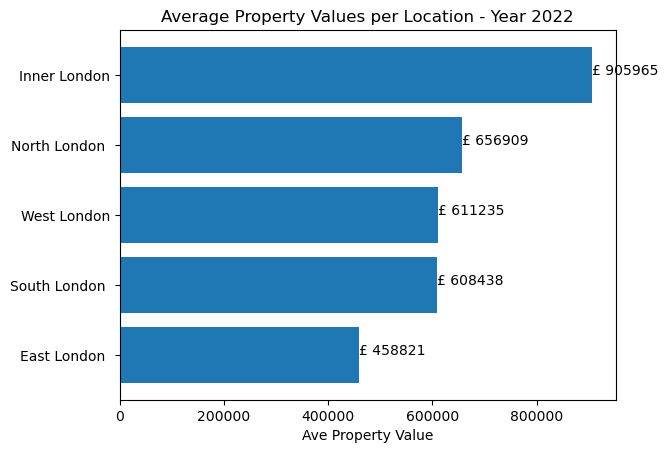

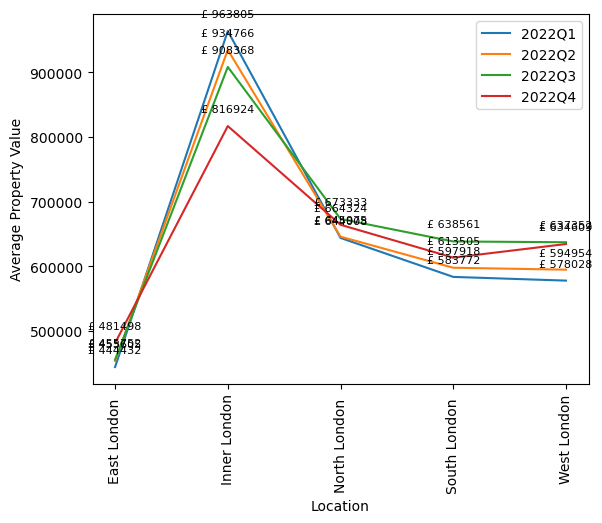

In [20]:
# Compare average property values for each location
temp = quarterly_mean[quarterly_mean['Year'] == '2022'].copy()
loc_means = temp.groupby('Location')['Value'].mean().sort_values()
plt.barh(loc_means.index, loc_means.values)
# Add labels to each bar
for i, v in enumerate(loc_means.values):
    plt.text(v, i, f"£ {str(int(v))}")

plt.xlabel('Ave Property Value')
plt.title('Average Property Values per Location - Year 2022')
plt.show()
# Plot average property values for each quarter
quarters = temp['Quarter'].unique()
    
for q in quarters:
    q_temp = temp[temp['Quarter']==q]
    plt.plot(q_temp['Location'], q_temp['Value'], label=q)

    # Add labels to each data point
    for x, y in zip(q_temp['Location'], q_temp['Value']):
        label = "£ {:.0f}".format(y)
        plt.annotate(label, (x,y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

plt.legend()
plt.xticks(rotation=90)
plt.xlabel('Location')
plt.ylabel('Average Property Value')
plt.show()

## Group data by Property Type and get range value for each group

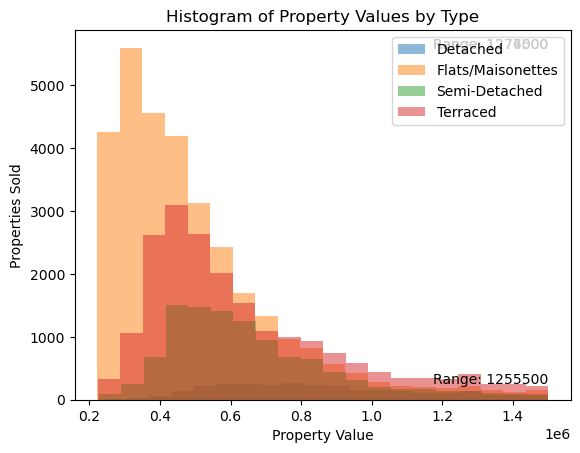

In [21]:

# group by Property Type and calculate the range of property values
grouped = df_last_year.groupby('Property Type')
ranges = grouped['Value'].agg(lambda x: max(x) - min(x))

# create a histogram for each Property Type
for property_type, group in grouped:
    plt.hist(group['Value'], bins=20, alpha=0.5, label=property_type)

    # add an annotation with the range of property values
    x_pos = group['Value'].max()
    y_pos = plt.ylim()[1] * 0.95
    plt.annotate(f'Range: {ranges[property_type]}', (x_pos, y_pos), ha='right')

plt.legend()
plt.xlabel('Property Value')
plt.ylabel('Properties Sold')
plt.title('Histogram of Property Values by Type')
plt.show()

# Line graphs

In [22]:
df.head(10)

,Id,Purchased Date,Postcode,Property Type,Value,New Build,Estate Type,Transaction Category,Saon,Paon,...,Town,District,County,URL,Inner-Outer,Population,Location,Year,Quarter,Month
Date Index,,,,,,,,,,,,,,,,,,,,,
2018-11-30,7E86B6FB-423C-458C-E053-6B04A8C0C84C,2018-11-30,BR1 1AA,Flats/Maisonettes,99000,False,Leasehold,Standard Price Paid,Flat 28,Henry House,...,Bromley,Bromley,Greater London,http://landregistry.data.gov.uk/data/ppi/trans...,Outer London,318300.0,South London,2018,2018Q4,2018-11
2018-11-23,7E86B6FB-4232-458C-E053-6B04A8C0C84C,2018-11-23,BR1 1AF,Flats/Maisonettes,400000,False,Leasehold,Standard Price Paid,Flat 12,William House,...,Bromley,Bromley,Greater London,http://landregistry.data.gov.uk/data/ppi/trans...,Outer London,318300.0,South London,2018,2018Q4,2018-11
2018-08-23,773788C3-19BF-2CE4-E053-6C04A8C05E57,2018-08-23,BR1 1AF,Flats/Maisonettes,295000,False,Leasehold,Standard Price Paid,Flat 16,William House,...,Bromley,Bromley,Greater London,http://landregistry.data.gov.uk/data/ppi/trans...,Outer London,318300.0,South London,2018,2018Q3,2018-08
2018-05-10,7011B109-CAF9-8ED6-E053-6B04A8C075C1,2018-05-10,BR1 1AF,Flats/Maisonettes,315000,False,Leasehold,Standard Price Paid,Flat 20,William House,...,Bromley,Bromley,Greater London,http://landregistry.data.gov.uk/data/ppi/trans...,Outer London,318300.0,South London,2018,2018Q2,2018-05
2018-03-14,6B32222C-9AAE-01F1-E053-6C04A8C0D2C8,2018-03-14,BR1 1AF,Flats/Maisonettes,275000,False,Leasehold,Standard Price Paid,Flat 35,William House,...,Bromley,Bromley,Greater London,http://landregistry.data.gov.uk/data/ppi/trans...,Outer London,318300.0,South London,2018,2018Q1,2018-03
2018-06-08,726BF13B-37AA-0A46-E053-6C04A8C01D0D,2018-06-08,BR1 1AF,Flats/Maisonettes,315000,False,Leasehold,Standard Price Paid,Flat 44,William House,...,Bromley,Bromley,Greater London,http://landregistry.data.gov.uk/data/ppi/trans...,Outer London,318300.0,South London,2018,2018Q2,2018-06
2018-05-25,7011B109-CAF5-8ED6-E053-6B04A8C075C1,2018-05-25,BR1 1AF,Flats/Maisonettes,312000,False,Leasehold,Standard Price Paid,Flat 45,William House,...,Bromley,Bromley,Greater London,http://landregistry.data.gov.uk/data/ppi/trans...,Outer London,318300.0,South London,2018,2018Q2,2018-05
2018-03-28,6B32222C-9AB2-01F1-E053-6C04A8C0D2C8,2018-03-28,BR1 1AF,Flats/Maisonettes,420000,False,Leasehold,Standard Price Paid,Flat 47,William House,...,Bromley,Bromley,Greater London,http://landregistry.data.gov.uk/data/ppi/trans...,Outer London,318300.0,South London,2018,2018Q1,2018-03
2018-10-09,79A74E22-11B6-1289-E053-6B04A8C01627,2018-10-09,BR1 1AF,Flats/Maisonettes,330000,False,Leasehold,Standard Price Paid,Flat 49,William House,...,Bromley,Bromley,Greater London,http://landregistry.data.gov.uk/data/ppi/trans...,Outer London,318300.0,South London,2018,2018Q4,2018-10


In [23]:
df['Month'] = pd.to_datetime(df['Purchased Date']).dt.to_period('M')
# Filter out Transaction Category with value 'Standard Price Paid'
temp = df[df['Transaction Category'] != 'Standard Price Paid']
aggregated_df = temp.groupby(['Month', 'Location', 'District', 'Town', 'Property Type', 'New Build', 'Estate Type']).agg({'Value': 'mean', 'Id': 'count'})
aggregated_df=aggregated_df.rename(columns = {'Id':'Properties Sold'})
aggregated_df = aggregated_df.reset_index()

# Other type of graphs

## Heatmap

Text(0.5, 1.0, 'Average Property Value by Location and Property Type')

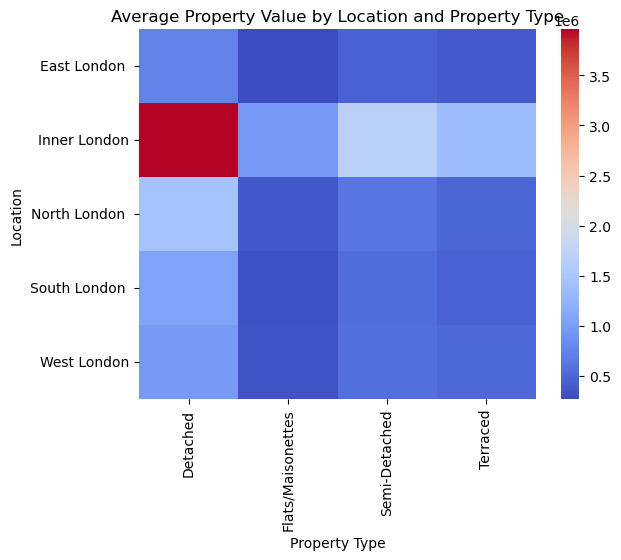

In [24]:
temp = aggregated_df.pivot_table(values='Value', index='Location', columns='Property Type')
sns.heatmap(temp, cmap='coolwarm')
plt.xlabel('Property Type')
plt.ylabel('Location')
plt.title('Average Property Value by Location and Property Type')

Text(0.5, 1.0, 'Distribution of Property Values by Estate Type')

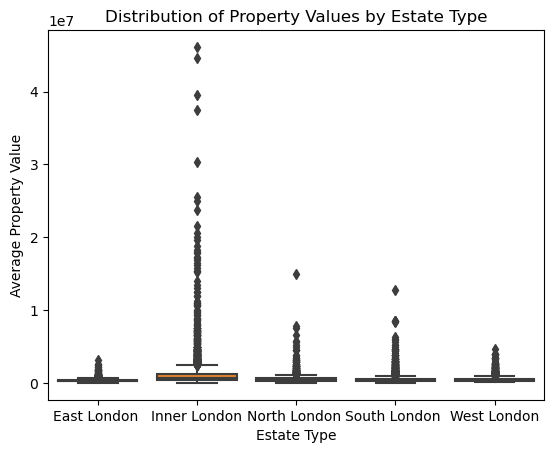

In [25]:
# Boxplot
temp = aggregated_df.copy()
sns.boxplot(data=temp, x='Location', y='Value')
plt.xlabel('Estate Type')
plt.ylabel('Average Property Value')
plt.title('Distribution of Property Values by Estate Type')

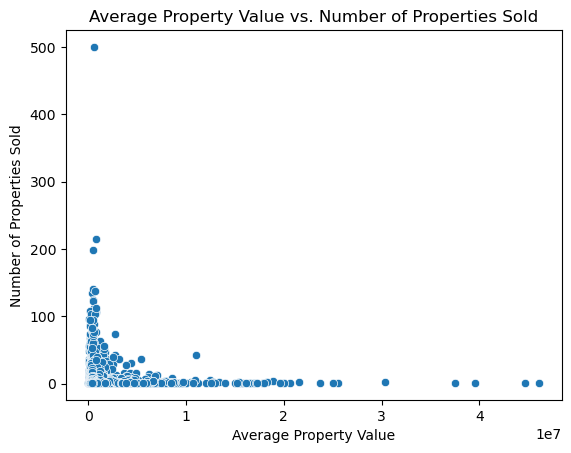

In [26]:
temp = aggregated_df.copy()
# Create a scatter plot
sns.scatterplot(data=temp, x='Value', y='Properties Sold')

# Set the plot title and axis labels
plt.title('Average Property Value vs. Number of Properties Sold')
plt.xlabel('Average Property Value')
plt.ylabel('Number of Properties Sold')
plt.show()

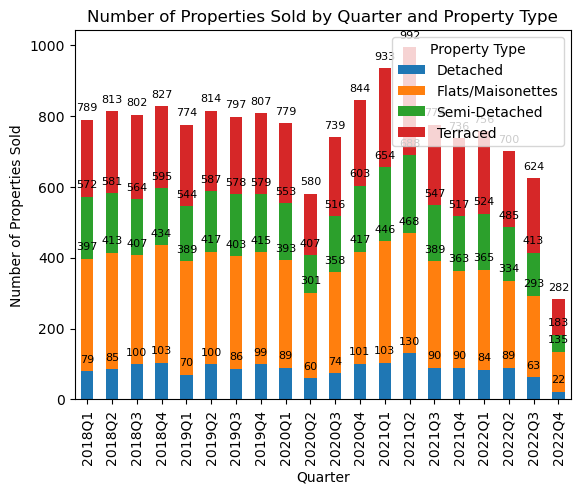

In [27]:
temp = aggregated_df.copy()
temp['Quarter'] = pd.to_datetime(temp['Month'].astype(str)).dt.to_period('Q')

# group data by quarter and property type, and count number of properties sold
quarterly_counts = temp.groupby(['Quarter', 'Property Type'])['Properties Sold'].count().unstack()

# create stacked bar chart
ax = quarterly_counts.plot(kind='bar', stacked=True)

# set labels and title
ax.set_xlabel('Quarter')
ax.set_ylabel('Number of Properties Sold')
ax.set_title('Number of Properties Sold by Quarter and Property Type')

# annotate values on each bar
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=8, padding=5)
plt.show()

# Generating some predictability trends

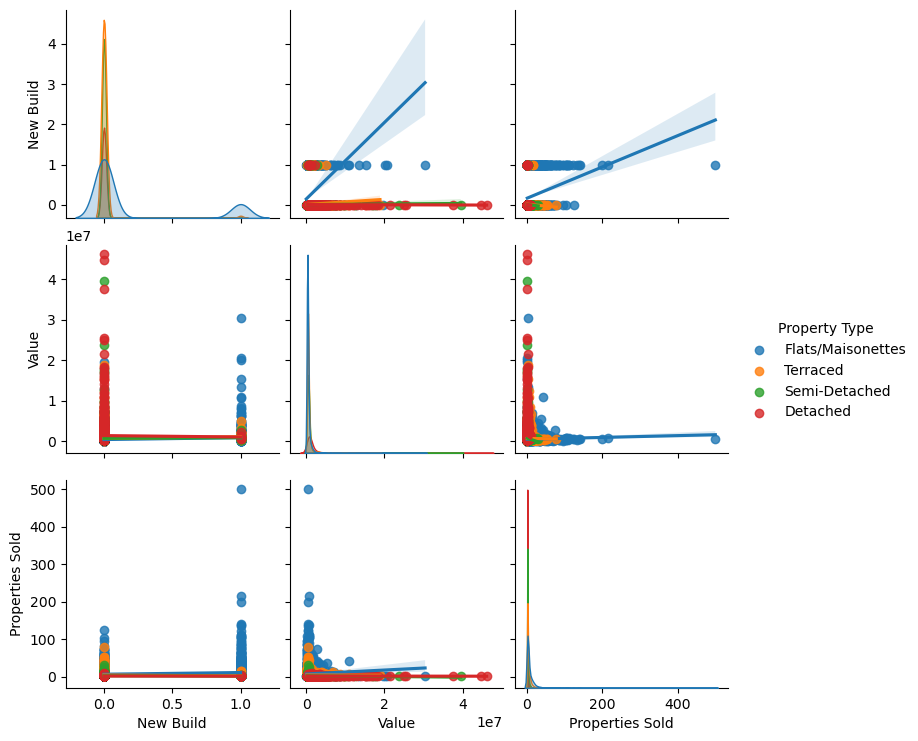

In [28]:
sns.pairplot(aggregated_df, hue='Property Type', kind='reg');


In [ ]:
temp = df.copy()
# Create a new column for year
temp["Year"] = temp.index.year

# Reset the index to make "Purchased Date" a regular column
temp = temp.reset_index()

# Calculate the mean property value for each year
yearly_avg_value = temp.groupby("Year")["Value"].mean().reset_index()

# Calculate the total number of properties sold for each year
yearly_total_sales = temp.groupby("Year")["Id"].count().reset_index()
yearly_total_sales = yearly_total_sales.rename(columns = {'Id':'Properties Sold'})

yearly_total_sales


In [ ]:

# Visualize the trends
sns.lineplot(data=yearly_avg_value, x="Year", y="Value")
plt.title("Average Property Value by Year")
plt.xlabel("Year")
plt.ylabel("Average Property Value")
plt.show()

sns.lmplot(data=yearly_avg_value, x="Year", y="Value")
plt.title("Average Property Value by Year")
plt.xlabel("Year")
plt.ylabel("Average Property Value")
plt.show()

In [ ]:

sns.lineplot(data=yearly_total_sales, x="Year", y="Properties Sold")
plt.title("Total Property Sales by Year")
plt.xlabel("Year")
plt.ylabel("Total Property Sales")
plt.show()

sns.lmplot(data=yearly_total_sales, x="Year", y="Properties Sold")
plt.title("Total Property Sales by Year")
plt.xlabel("Year")
plt.ylabel("Total Property Sales")
plt.show()

In [ ]:

# Models
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Reporting
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

temp = df.copy()
# Create a new column for year
temp["Year"] = temp.index.year

# Reset the index to make "Purchased Date" a regular column
temp = temp.reset_index()

# Concatenate data for all years up to 2022
historical_data = temp[temp["Year"] < 2023]
historical_value = historical_data[["Year", "Value"]]
historical_value = pd.pivot_table(historical_value, index="Year", values="Value", aggfunc="mean")
historical_sales = historical_data[["Year", "Id"]]
historical_sales = pd.pivot_table(historical_sales, index="Year", values="Id", aggfunc="count")

# Train a linear regression model to predict property prices for 2023
lr = LinearRegression()
lr.fit(historical_value.index.values.reshape(-1, 1), historical_value["Value"])
predicted_value_lr = lr.predict([[2023]])

# Train a decision tree regression model to predict property prices for 2023
dtr = DecisionTreeRegressor()
dtr.fit(historical_value.index.values.reshape(-1, 1), historical_value["Value"])
predicted_value_dtr = dtr.predict([[2023]])

# Plot the predicted values on the same chart as the historical data
sns.lineplot(data=historical_value)
plt.plot([2023], predicted_value_lr, "o", label="Linear Regression")
plt.plot([2023], predicted_value_dtr, "o", label="Decision Tree Regression")
plt.legend()
plt.title("Average Property Value by Year")
plt.xlabel("Year")
plt.ylabel("Average Property Value")
plt.show()

In [ ]:
df['Quarter'] = pd.to_datetime(df['Purchased Date']).dt.to_period('Q')
# Filter out Transaction Category with value 'Standard Price Paid'
temp = df[df['Transaction Category'] != 'Standard Price Paid']
aggregated_df = temp.groupby(['Quarter', 'Location', 'District', 'Town', 'Property Type', 'New Build', 'Estate Type']).agg({'Value': 'mean', 'Id': 'count'})
aggregated_df=aggregated_df.rename(columns = {'Id':'Properties Sold'})
aggregated_df = aggregated_df.reset_index()

temp = aggregated_df.copy()
temp['Quarter'] = pd.to_datetime(temp['Quarter'].astype(str)).dt.to_period('Q')
temp.set_index("Quarter", inplace=True)
temp_summary = temp[['Location','New Build','Property Type','Value','Properties Sold']]
temp


In [ ]:
# resample the data by quarter and aggregate the mean property price by location
df_q = temp_summary.resample("Q").agg({"Value": "mean", "Location": "first"})

sns.jointplot(data=temp_summary, x='Value', y='Properties Sold',kind='reg')


In [ ]:

# create a pairplot with the average property price matrix by location
# sns.pairplot(df_q,, hue="Location", height=5, aspect=1.5)
sns.pairplot(temp_summary, hue='Location', kind='reg');

In [ ]:
sns.pairplot(temp_summary)

In [ ]:
# Displaying a heatmap over location area map of Greater London

In [ ]:

import geopandas as gpd
import contextily as ctx


# filter the data to Greater London area only
greater_london = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
greater_london = greater_london[greater_london["name"] == "United Kingdom"].explode()
greater_london = greater_london[greater_london["admin"].str.contains("London")]
greater_london = greater_london.to_crs(epsg=4326)

temp = df.copy()
# aggregate the data by location and one of the specified columns
agg_column = "Postcode"  # choose one of "Postcode", "Town", "District", "Locality", "County", "Location"
df_agg = temp.groupby(["Location", agg_column])["Value"].mean().reset_index()

# merge the data with the Greater London geodataframe
london_data = pd.merge(greater_london, df_agg, on="Location", how="outer")

# create a heatmap of the aggregated data
fig, ax = plt.subplots(figsize=(10, 10))
london_data.plot(column="Value", cmap="Reds", legend=True, ax=ax)
ax.set_axis_off()

# add a basemap using contextily
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

###### 